In [1]:
import re
import random
import pandas as pd
import hashlib

In [2]:
with open("certcards2.txt", mode="r", encoding="utf8") as f:
    all_cards = f.read()

card_split_pattern = r"\n\n\n\d+\n"
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r"(.+?)\n([\s\S]+)", re.DOTALL)
cards = [
    (match.group(1), match.group(2))
    for cstring in all_cards
    if (match := re.search(card_pattern, cstring))
]

# removing the cards that have no content and trimming
cards = [
    (subject, stripped_content)
    for subject, content in cards
    if len(stripped_content := content.strip()) > 5
]


def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode("utf-8")).hexdigest()


def remake_card_document(
    existing_cards: pd.DataFrame, filename: str = "certcards2.txt"
):
    with open(filename, mode="w", encoding="utf8") as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write("\n" * 6)
            f.write(str(i) + "\n")
            f.write(row["head"] + "\n")
            f.write(row["body"])
            i += 1
    print(f"Cards found: {existing_cards.shape[0]}")
    print(f"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=["head", "body"])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards["hash"] = existing_cards["body"].apply(hash_string_md5)

card_ages = pd.read_json("card_ages.json")
card_ages = card_ages.drop_duplicates(subset=["hash"], keep="first")

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[["hash", "age"]],
    left_on="hash",
    right_on="hash",
    how="left",
)


cards_to_age["head"] = cards_to_age["head"].str.strip()

# remove headers I don't want anymore
undesired_headers = ["CCH Axcess"]
cards_to_age = cards_to_age.loc[~cards_to_age["head"].isin(undesired_headers), :].copy()

cards_to_age["age"] = cards_to_age["age"].fillna(0)

age_factor = 1.01
cards_to_age["age"] = cards_to_age["age"] * age_factor

cards_to_age["age"] = cards_to_age["age"] + [
    random.expovariate(0.5) for _ in cards_to_age.index
]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
mean = cards_to_age["age"].mean()
threshold = .005+(mean/1000)
shuffle_role = random.random()
print(f"{shuffle_role=:.6f}; {threshold=:.6f}")
if shuffle_role < threshold:
    cards_to_age["age"] = cards_to_age["age"] * [
        random.expovariate(1.3) for _ in cards_to_age.index
    ]

# Adding priority age growth to cards for upcoming certifications
priority_headers = [
    "Django", 
    "Python + Oauth2.0"
    ]
priority_cards_mask = cards_to_age["head"].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, "age"] = (
    cards_to_age.loc[priority_cards_mask, "age"] * 1.0718
)

cards_to_age = cards_to_age.drop_duplicates(subset=["hash"], keep="first")

cards_to_age["subject_mean_age"] = cards_to_age.groupby("head")["age"].transform("mean")
cards_to_age["subject_highest_age"] = cards_to_age.groupby("head")["age"].transform(
    "max"
)
cards_to_age["subject_age_sum"] = cards_to_age.groupby("head")["age"].transform("sum")
cards_to_age["head_random_roll"] = cards_to_age.groupby("head")["head"].transform(
    lambda x: random.random()
)
cards_to_age["head_count"] = cards_to_age.groupby("head")["head"].transform("count")


cards_to_age.sort_values("hash")[["age", "head", "hash"]].to_json(
    "card_ages.json", indent=2
)

existing_cards = cards_to_age

shuffle_role=0.924451; threshold=0.054587


In [3]:
ave_order = ('age', 'mean')
sum_order = ('age', 'sum')

stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(ave_order)
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Ansible,78.643253,1.966081,8.768928,40
ODBC,53.953103,3.372069,11.778202,16
Power BI,45.739852,15.246617,19.715170,3
Ubuntu,660.508451,25.404171,80.482704,26
eDiscovery,1423.784544,26.366380,92.081215,54
Network Terms,406.935195,27.129013,45.078560,15
SSH + SCP,947.389593,32.668607,108.635860,29
GUI Docker Container,698.332827,33.253944,64.405537,21
Exchange Online and Defender,1365.549688,35.014095,86.883467,39
"The Mines of the Behemoth, Shea",1825.912093,37.263512,143.548956,49


# Histogram

sum of ages: ~39889.32


<Axes: >

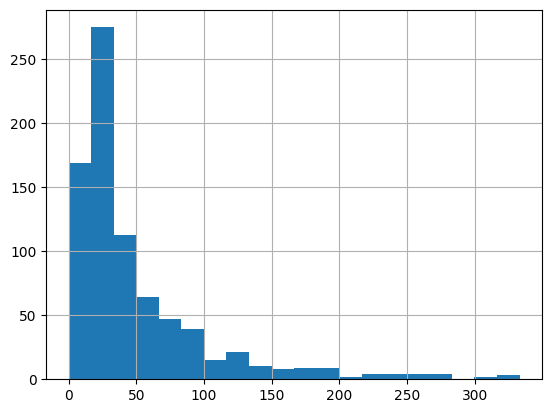

In [4]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~39889.32


<Axes: >

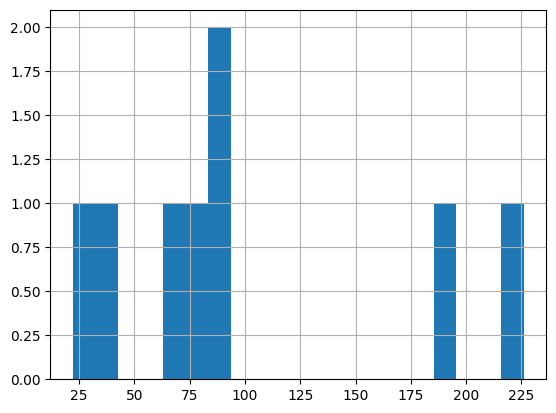

In [5]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Python + Oauth2.0']['age'].hist(bins=20)

# Completely Random Shuffle

In [6]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [7]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [8]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // m

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [9]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [10]:
n = random.choice([2, 3, 3, 4, 4, 5])

existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

if existing_cards['age'].sum() > 0:
    existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# existing_cards.sort_values(['age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 802
Total card age: 39889.32


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
0,Microsoft Purview,You can apply just one sensitivity label to an...,50f85d7bb8f9e04601a53f72976eeb45,333.048376,83.547742,-333.048376,3174.814209,0.446598,38,0,0,-333.048376
265,Microsoft Purview,Data understanding is about ensure data has qu...,9a95bac80e7ba590c49d6bcab8edaf38,319.407622,83.547742,-333.048376,3174.814209,0.446598,38,1,0,-319.407622
523,Microsoft Purview,Microsoft Purview includes:\nSensitive informa...,3c753353c6695bdcff7b2121467b00ed,303.053336,83.547742,-333.048376,3174.814209,0.446598,38,2,0,-303.053336
1,Microsoft Purview,DLP policies can be applied to the following l...,1e0d0df316a1863273287a159447b6b6,269.807596,83.547742,-333.048376,3174.814209,0.446598,38,3,0,-269.807596
266,Microsoft Purview,Microsoft Purview includes:\nSensitive informa...,de3d4abdf1b524648b0f3a60653128ec,218.642919,83.547742,-333.048376,3174.814209,0.446598,38,4,0,-218.642919
73,Terraform Codebox,"In a Terraform module, names like ""main"" or ""t...",1b7ed79374e4be64070aa3e191990353,325.056945,62.684581,-325.056945,1880.537433,0.504077,30,0,0,-325.056945
337,Terraform Codebox,curl -L -o filename\nA command to download fil...,9579c5ea9be6402b1e145491fbb73226,267.242965,62.684581,-325.056945,1880.537433,0.504077,30,1,0,-267.242965
591,Terraform Codebox,Terraform modules allow you to organize and re...,30dc7c65ccaa1883bdec852a7b452264,214.556739,62.684581,-325.056945,1880.537433,0.504077,30,2,0,-214.556739
74,Terraform Codebox,journalctl\nA log viewing tool used to inspect...,4f714c682ad20367a1ae8cad399b1722,181.272368,62.684581,-325.056945,1880.537433,0.504077,30,3,0,-181.272368
338,Terraform Codebox,Shebang (#!/bin/bash)\nThe first line in many ...,1e5d7b5c48fc5c9694191b41f91bae92,98.296648,62.684581,-325.056945,1880.537433,0.504077,30,4,0,-98.296648


## Card Count

In [11]:
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()

# choices = ['floor', 'mod']
# option = random.choice(choices)
# if option == 'floor':
#     n=5
#     existing_cards['n_fold'] = existing_cards['count'] // n
#     print("floor dividing for n-fold")
# elif option == 'mod':
#     n=3
#     existing_cards['n_fold'] = existing_cards['count'] % n
#     print("modulo for n-fold")
# else: raise NotImplementedError


# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [12]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [13]:
existing_cards.head(10)['age'].sum()

np.float64(2530.3855149498218)

In [14]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
0,Microsoft Purview,You can apply just one sensitivity label to an...,50f85d7bb8f9e04601a53f72976eeb45,333.048376,83.547742,-333.048376,3174.814209,0.446598,38,0,0,-333.048376
73,Terraform Codebox,"In a Terraform module, names like ""main"" or ""t...",1b7ed79374e4be64070aa3e191990353,325.056945,62.684581,-325.056945,1880.537433,0.504077,30,0,0,-325.056945
265,Microsoft Purview,Data understanding is about ensure data has qu...,9a95bac80e7ba590c49d6bcab8edaf38,319.407622,83.547742,-333.048376,3174.814209,0.446598,38,1,0,-319.407622
34,Azure Functions Core Tools,Get-Command (PowerShell) – Finds which executa...,0635fb1571b8f8e4280232ceb6070d75,303.258950,73.582950,-303.258950,1250.910146,0.043602,17,0,0,-303.258950
523,Microsoft Purview,Microsoft Purview includes:\nSensitive informa...,3c753353c6695bdcff7b2121467b00ed,303.053336,83.547742,-333.048376,3174.814209,0.446598,38,2,0,-303.053336
1,Microsoft Purview,DLP policies can be applied to the following l...,1e0d0df316a1863273287a159447b6b6,269.807596,83.547742,-333.048376,3174.814209,0.446598,38,3,0,-269.807596
126,Linux,Process\nA running instance of a program with ...,f5a712ebdaa4ff23d911d97a945af7a8,269.236688,53.084553,-269.236688,1698.705689,0.588784,32,0,0,-269.236688
23,JavaScript Concepts,"For objects, by default String returns an unhe...",cc7c3bc61969fcf92a11320dd7feed10,267.440144,73.639771,-267.440144,2430.112432,0.799273,33,0,0,-267.440144
337,Terraform Codebox,curl -L -o filename\nA command to download fil...,9579c5ea9be6402b1e145491fbb73226,267.242965,62.684581,-325.056945,1880.537433,0.504077,30,1,0,-267.242965
51,Django,Collectstatic Step\nPart of Django deployment ...,52e99cf555a329f05921f2a497c12457,260.552237,72.815666,-260.552237,1019.419330,0.616651,14,0,0,-260.552237


In [15]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 49.737'